
# Descripción del Problema
Un banco internacional otorga créditos de consumo y revolving a un grupo de clientes al pasar de los meses, algunos de ellos registran morosidad, es decir no paga como se había comprometido. Ha decidido que con esta información encomendar al área de Data Science hacer un modelo para predecir el comportamiento de futuros buenos pagadores.

## Objetivos del estudio

Elaborar un modelo predictivo que permita realizar una calificación de pago de un potencial deudor, para automatizar la decisión de otorgar o no un préstamo a un cliente.

## Motivación
Mejorar las métricas de pago de los clientes, con los siguientes objetivos:
-	Identificar a tiempo los clientes que tendrán morosidad.
-	Evitar la fuga de capitales dado el no pago de los créditos por parte de los clientes.
-	Mejorar las nuevas oportunidades que se puede otorgar a los clientes.

Al ser las dos variables objetivo discretas, trataremos al problema con **Modelos de Clasificación**. mas adelante declararemos una grilla de búsqueda tentativa con los respectivos modelos e hiperparámetros.

## El procedimiento para esta problemática es la siguiente:

* Exploración de variables perdidas.
* Binarizar las variable de entrenamiento y validación.
* Obtener variables con mayor correlación.
* Exploración de atributos y variable objetivo.
* Entrenamiento de modelos con grilla de búsqueda.
* Elegir mejor modelo y reportar desempeño.

## Métricas y división de muestras

#### **Métricas**

Para medir el **desempeño de los modelos de clasificación** y obtener los dos mejores, decidiremos las métricas en función al des balance de clases que presenta los datos, F1 y curva ROC, El proceso será el siguiente:

* Realizamos una búsqueda de grilla con GridSearchCV, con un KFold de 5.

* Con el best estimator de cada modelo predecimos en conjunto de validación que nunca entró en la Grilla de Búsqueda.

* Con los datos predichos, obtenemos un Puntaje de Validación y elegimos mejor modelo a partir del puntaje, evaluando underfitting y overfitting.

In [1]:
# Import our libraries we are going to use for our data analysis.
import pandas as pd
import numpy as np
import pickle
from joblib import dump, load

# Plotly visualizations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import  OneHotEncoder
import helpers as hps

# Modelamiento
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Metrics
from sklearn.metrics import  classification_report, roc_auc_score, roc_curve, confusion_matrix, plot_roc_curve

In [2]:
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Semilla pseudoaleatoria
REP_SEED = 42

In [3]:
df = pd.read_csv('Desafio4_modelamiento.csv')
df.columns = df.columns.str.lower()
df.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Dimensiones del pandas DataFrame
df.shape

(307511, 122)

### 3.1 Analisis de nulos

In [5]:
#Features con valores nulos ordenados en forma descendente
features_with_nulls = df.isnull().sum() / len(df) * 100
features_with_nulls.sort_values(ascending = False)

commonarea_medi             69.872297
commonarea_avg              69.872297
commonarea_mode             69.872297
nonlivingapartments_mode    69.432963
nonlivingapartments_avg     69.432963
                              ...    
name_housing_type            0.000000
name_family_status           0.000000
name_education_type          0.000000
name_income_type             0.000000
sk_id_curr                   0.000000
Length: 122, dtype: float64

* Se aplica el criterio de eliminar columna con mas de 50% nulos

In [6]:
features_with_nulls = features_with_nulls[features_with_nulls.values >= 50.0]
df.drop(labels = features_with_nulls.index, axis = 1, inplace = True)
print("La cantidad de columnas eliminadas es de", len(features_with_nulls))
print('El total de columnas después de la eliminación es de', df.shape[1])

La cantidad de columnas eliminadas es de 41
El total de columnas después de la eliminación es de 81


### 3.2 Análisis de datos nulos y atípicos

#### 3.2.1 Análisis variable "amt_annuity"

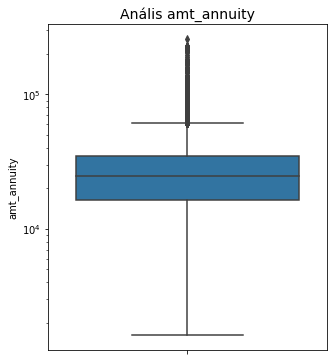

In [7]:
plt.figure(figsize=(5,6))
sns.boxplot(y = df['amt_annuity'])
plt.yscale('log')
plt.title("Anális amt_annuity", fontsize=14)
plt.show()

Inferencia:
* A partir del diagrama podemos ver que hay varios valores atipicos y nulos,la diferencia entre máximo y mínimo es bastante marcada. Entonces estamos tomando el valor de la mediana para reemplazar esos valores nulos.

#### 3.2.2 Análisis variable "days_employed"

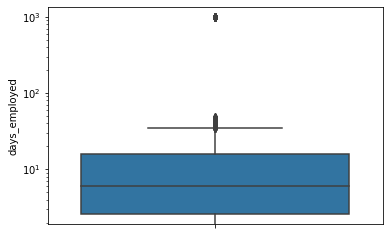

In [9]:
sns.boxplot(y=abs(df['days_employed'])/365)
plt.yscale('log') 
plt.show()

In [10]:
# Eliminación de valores atípicos:
df["days_employed"].replace({365243: np.nan}, inplace = True)

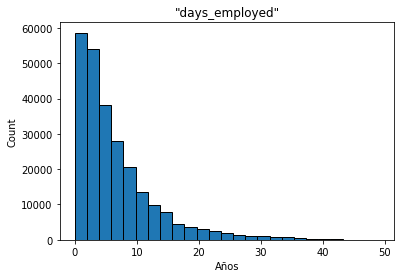

In [12]:
# Distribución days_employed
plt.hist(df['days_employed'] / -365, edgecolor = 'k', bins = 25)
plt.title('"days_employed"')
plt.xlabel('Años')
plt.ylabel('Count');

Inferencia: 
* La columna 'Days_Employed' básicamente se refiere a la cantidad de días antes de la solicitud de préstamo   
que el cliente comenzó su primer trabajo.

#### 3.2.3 Análisis variable "days_birthday"

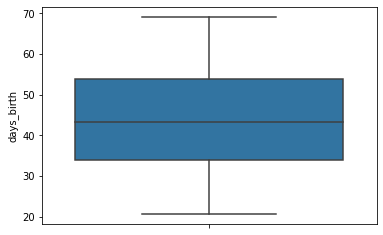

In [13]:
df['days_birth'].describe()
sns.boxplot(y=abs(df['days_birth']/365))
plt.show()

In [14]:
df['days_birth'] = abs(df['days_birth'])

Inferencia:
* La columna 'days_birth' básicamente se refiere a la cantidad de días de vida del cliente comenzó.   
Dado que los valores son  negativos, fueron transformados los datos en años y convertido en valores   
positivos para ver los valores atípicos.  

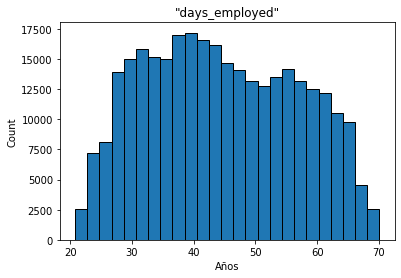

In [17]:
plt.hist(df['days_birth'] / 360, edgecolor = 'k', bins = 25)
plt.title('"days_employed"')
plt.xlabel('Años')
plt.ylabel('Count');

#### 3.2.4 Análisis variable "days_last_phone_change"

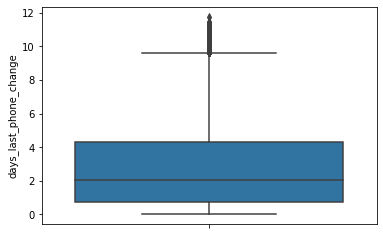

In [19]:
df['days_last_phone_change'].describe()
sns.boxplot(y=abs(df['days_last_phone_change'] / 365))
plt.show()

Inferencia: 
* La columna 'days_last_phone_change'  se refiere a la cantidad de días de la postulación cambia el telefono.   
Fueron transformados los datos en años para ver los valores atípicos.  

#### 3.2.5 Análisis variable "amt_credit"

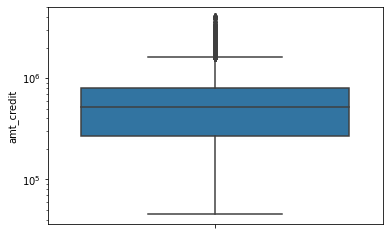

In [20]:
df['amt_credit'].describe()
sns.boxplot(y=df['amt_credit'])
plt.yscale('log')
plt.show()

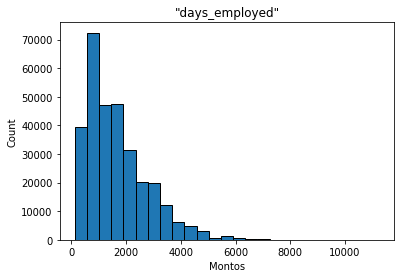

In [21]:
plt.hist(df['amt_credit']/360, edgecolor = 'k', bins = 25)
plt.title('"days_employed"')
plt.xlabel('Montos')
plt.ylabel('Count');

####  3.2.6 Análisis variable "amt_annuity"

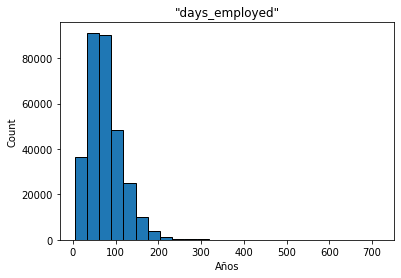

In [23]:
plt.hist(df['amt_annuity'] / 360, edgecolor = 'k', bins = 25)
plt.title('"days_employed"')
plt.xlabel('Años')
plt.ylabel('Count');

Inferencia: 
* La columna 'amt_annuity'  se refiere a la Anualidad del préstamo. Tiene valores atípicos, pero se decide mantenerlos ya que los valores posibles en el contexto

#### 3.2.7 Análisis variable "region_population_relative"

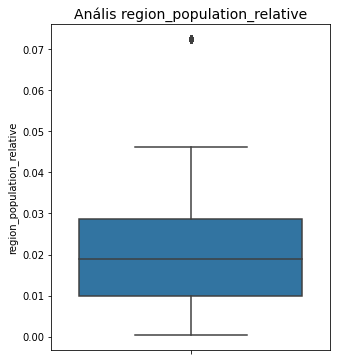

In [24]:
plt.figure(figsize=(5,6))
sns.boxplot(y = df['region_population_relative'])
plt.title("Anális region_population_relative", fontsize=14)
plt.show()

Inferencia
 * La columna 'region_population_relative'  se refiere a población donde vive el cliente (la variable está normalizada),   
 donde valores más altos significan que el cliente vive en una región más poblada. Tiene valores atípicos, pero se decide   
 mantenerlos ya que so valores posibles en el contexto.  

#### 3.2.8 Análisis variable "region_rating_client"

In [ ]:
print(df['region_rating_client'].mean())
print(df['region_rating_client'].median())
print(df['region_rating_client'].describe())

### 3.2.9 Análisis variable "code_gender"

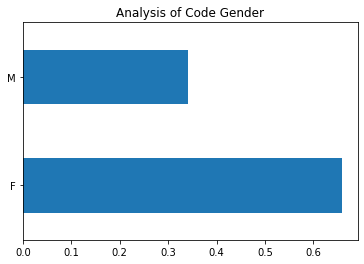

In [26]:
df.loc[df['code_gender']=='XNA','code_gender']='F'
df['code_gender'].value_counts()
df['code_gender'].value_counts(normalize=True).plot.barh(title='Analysis of Code Gender')
plt.show()

Inferencia
* La columna 'code_gender'  se refiere al genero del cliente (la variable está normalizada, donde valores  
 más altos significan que el cliente vive en una región más poblada. Tiene valores atípicos, pero se decide   
 mantenerlos ya que so valores posibles en el contexto.  

#### 3.2.10 Análisis variable "days_id_publish"

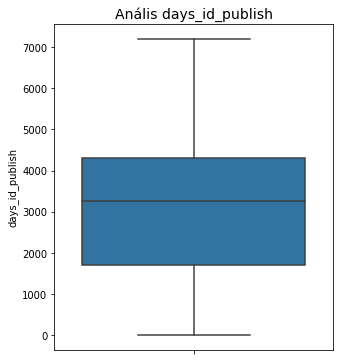

In [27]:
plt.figure(figsize=(5,6))
sns.boxplot(y = abs(df['days_id_publish']))
plt.title("Anális days_id_publish", fontsize=14)
plt.show()

Inferencia: 
* La columna 'days_id_publish'  se refiere a la cantidad de días previos a la modificación de  
 su documento de identificación con el cual postulación al préstamo. Fueron transformados los   
 datos en años para ver los valores atípicos.  

#### 3.2.11 Análisis variable "reg_city_not_work_city"

In [30]:
df['reg_city_not_work_city'].value_counts()

0    236644
1     70867
Name: reg_city_not_work_city, dtype: int64

Inferencia:
 * reg_city_not_work_city Identificador booleano si es que la dirección permanente   
 no concuerda con la dirección del trabajo, se confirma que contenga información valida.  

In [31]:
df['reg_city_not_work_city'].describe()

count    307511.000000
mean          0.230454
std           0.421124
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: reg_city_not_work_city, dtype: float64

Inferencia
 * reg_city_not_work_city Identificador booleano si es que la dirección permanente   
 no concuerda con la dirección del trabajo, se confirma que contenga información valida.  

#### 3.2.13 Análisis variable "emergencystate_mod"

In [33]:
df['emergencystate_mode'].value_counts('%')

No     0.985608
Yes    0.014392
Name: emergencystate_mode, dtype: float64

Inferencia
 * emergencystate_mode identificador que indica Yes o No, se confirma que contenga información válida

#### 3.2.14 Análisis variable "live_city_not_work_city"

In [34]:
df['live_city_not_work_city'].value_counts('%')

0    0.820445
1    0.179555
Name: live_city_not_work_city, dtype: float64

Inferencia
* live_city_not_work_city identificador Identificador booleano si es que la dirección   
de contacto del cliente no concuerda con la dirección del trabajo, se confirma que contenga   
información valida.  

#### 3.2.16 Análisis variable "amt_income_total"

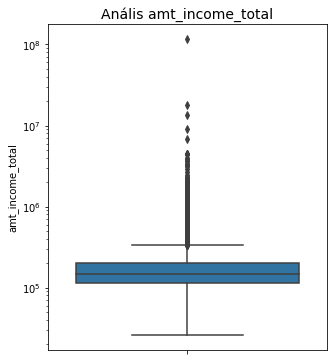

In [36]:
plt.figure(figsize=(5,6))
sns.boxplot(y = df['amt_income_total'])
plt.yscale('log')
plt.title("Anális amt_income_total", fontsize=14)
plt.show()

Inferencia:
* amt_income_total ingreso total del cliente, se confirma que contenga información valida,   
existen valores atípicos, pero se decide mantener la información.  

### 3.2.17 Análisis variable "reg_city_not_live_city"

In [37]:
df['reg_city_not_live_city'].value_counts('%')

0    0.921827
1    0.078173
Name: reg_city_not_live_city, dtype: float64

Inferencia
* reg_city_not_live_city, identificador booleano si es que la dirección permanente   
no concuerda con la dirección de contacto, se confirma que contenga información válida.  

#### 3.2.18 Análisis variable "emergencystate_mode"


In [38]:
df['emergencystate_mode'].value_counts('%')

No     0.985608
Yes    0.014392
Name: emergencystate_mode, dtype: float64

Inferencia:
* emergencystate_mode Identificador booleano si es que la dirección permanente   
no concuerda con la dirección de contacto, se confirma que contenga información válida.  

#### 3.2.19 Análisis variable "days_registration"

In [ ]:
plt.figure(figsize=(5,6))
sns.boxplot(y = abs(df['days_registration']/365))
plt.title("Anális days_registration", fontsize=14)
plt.show()

Inferencia
* La columna 'days_registration' se refiere a la cantidad de días previos a la última  
 modificación de los registros del cliente previos a la postulación. Fueron transformados   
 los datos en años para ver los valores atípicos.  

### 3.3 Feature engineering

#### 3.3.1 Recodificación de variables binarias

In [39]:
df.loc[df['code_gender'] =='XNA','code_gender'] = 'F'
df['name_contract_type'] = np.where(df['name_contract_type'] == 'Cash loans', 0, 1)
df['code_gender'] = np.where(df['code_gender'] == 'F', 0, 1)
df['flag_own_car'] = np.where(df['flag_own_car'] == 'N', 0, 1)
df['flag_own_realty'] = np.where(df['flag_own_realty'] == 'Y', 0, 1)
df['emergencystate_mode'] = np.where(df['emergencystate_mode'] == 'No', 0, 1)

#### 3.3.2 Análisis de agrupación de atributos

In [40]:
df.select_dtypes('object').apply(pd.Series.nunique, axis= 0)

name_type_suite                7
name_income_type               8
name_education_type            5
name_family_status             6
name_housing_type              6
occupation_type               18
weekday_appr_process_start     7
organization_type             58
dtype: int64

#### 3.3.2.1 Análisis variable "occupation_type"

In [41]:
df['occupation_type'].value_counts()
df['occupation_type'] = hps.reduce_feature(['Waiters/barmen staff','Secretaries','Realty agents','HR staff','IT staff'], 'occupation_type',df)

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
other                     4493
Private service staff     2652
Low-skill Laborers        2093
Name: occupation_type, dtype: int64


#### 3.3.2.2 Análisis variable "name_income_type" 

In [42]:
df['name_income_type'].value_counts()
df['name_income_type'] = hps.reduce_feature(['Maternity leave', 'Student','Businessman','Unemployed'], 'name_income_type',df)

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
other                       55
Name: name_income_type, dtype: int64


In [43]:
df.select_dtypes('object').apply(pd.Series.nunique, axis= 0)

name_type_suite                7
name_income_type               5
name_education_type            5
name_family_status             6
name_housing_type              6
occupation_type               14
weekday_appr_process_start     7
organization_type             58
dtype: int64

#### 3.3.3 Análisis univariado y multivariado

#### 3.3.3.1 Distribución variable objetivo "target"

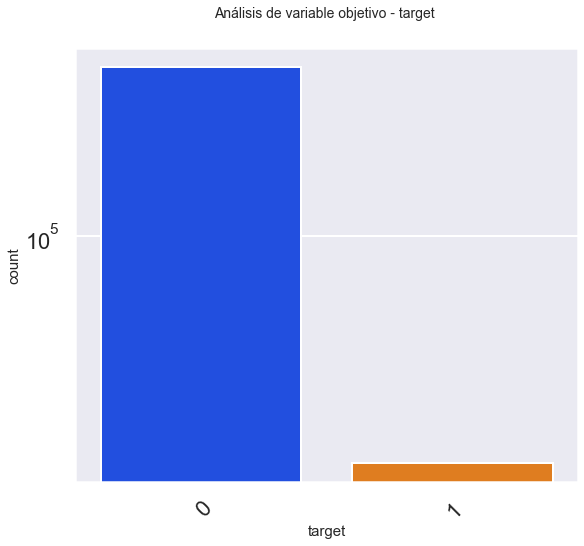

In [44]:
hps.plotfunc(df,"target", "Análisis de variable objetivo - target ")

Inferencia
* Se puede observar el desbalance de las clases

#### 3.3.3.2 Gráfico Monto de los créditos v/s variable objetivo "target"

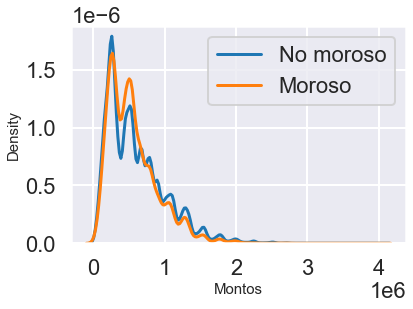

In [45]:
sns.kdeplot(df.loc[df['target'] == 0, 'amt_credit'] , label ='No moroso')
sns.kdeplot(df.loc[df['target'] == 1, 'amt_credit'] , label ='Moroso')
plt.xlabel('Montos') #modificación BA
plt.legend();

Inferencia 
* Cantidad de crédito es la cantidad solicitada por el cliente, se puede observar que la frecuencia   
es similar para ambos tipos de cliente, moroso y no moroso.  
* El gráfico parece sesgado a la derecha.  
* Se puede observar que se superponen mucho los morosos y los no morosos.  

#### 3.3.3.3 Gráfico días trabajados previo postulación v/s variable objetivo "target"

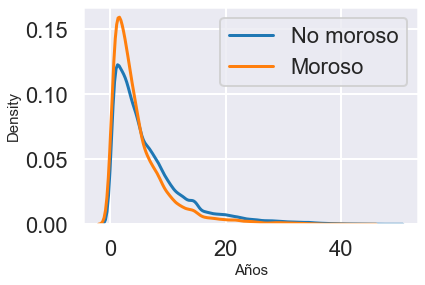

In [46]:
df['year_employed'] = abs(df['days_employed']) / 365
sns.kdeplot(df.loc[df['target'] == 0, 'year_employed'] , label = 'No moroso')
sns.kdeplot(df.loc[df['target'] == 1, 'year_employed'] , label='Moroso')
#plt.title('year')
plt.ylabel('Density')
plt.xlabel('Años') 
plt.legend();

Inferencia:
* Se puede observar  que existen clientes que tienen menos de 10 años de experiencia tenían dificultades para pagar los préstamos.

#### 3.3.3.4 Gráfico edad del cliente cuando solicito el prestamo v/s variable objetivo "target"

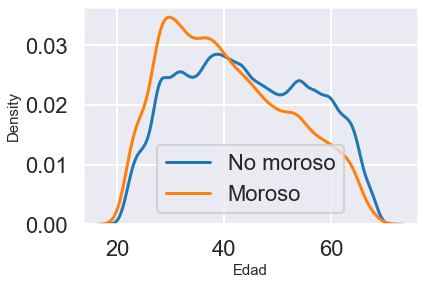

In [47]:
df['age_years'] = (-df['days_birth']) / 365
sns.kdeplot(abs(df.loc[df['target'] == 0, 'age_years']) , label = 'No moroso') #correción ba del absoluto
sns.kdeplot(abs(df.loc[df['target'] == 1, 'age_years']) , label='Moroso') #correción ba del absoluto
#plt.title('Age in years')
plt.ylabel('Density')
plt.xlabel('Edad') 
plt.legend();

Inferencia
* Los clientes de 20 y 40 años que tienen dificultades para pagar el préstamo.
* A medida que aumenta la edad, vemos que el grupo de edad (50–70) existen menos cantidad de morosos.
* Los clientes más jóvenes son más propensos a incumplir.

#### 3.3.3.5 Gráficos que evaluan puntajes de externo v/s variable objetivo "target"

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#axes[1].title.set_text('ext_source_2') #modificación ba
axes[0].set_xlabel('puntaje ext_source_2') #modificación ba
axes[0].set_ylabel('Density')
sns.kdeplot(df.loc[df['target'] == 0, 'ext_source_2'] , label = 'No moroso', ax=axes[0])
sns.kdeplot(df.loc[df['target'] == 1, 'ext_source_2'] , label = 'Moroso', ax=axes[0])
axes[0].legend()

#axes[2].title.set_text('ext_source_3') #modificación ba
axes[1].set_xlabel('puntaje ext_source_3') #modificación ba
axes[1].set_ylabel('Density')
sns.kdeplot(df.loc[df['target'] == 0, 'ext_source_3'] , label = 'No moroso', ax=axes[1])
sns.kdeplot(df.loc[df['target'] == 1, 'ext_source_3'] , label = 'Moroso', ax=axes[1])
axes[1].legend();

Inferencia
* Se puede observar que si Fuente externa 2 < 0.5 entonces el cliente incumplirá, si la Fuente externa 2 > 0.5 el cliente pagará, hay una separación visible entre dos clases.
* Se puede observar que si Fuente externa 3< 0.4 entonces el cliente incumplirá, si Fuente externa 3 > 0.4 el cliente pagará, hay una separación visible entre dos clases.

#### 3.3.3.6 Gráfico monto de créditos otorgados a clientes morosos v/s género

Inferencia:
Puntos a concluir del gráfico anterior para el objetivo = 0 (no morosos).
1. Los recuentos de mujeres son más altos que los de hombres.
2. Este gráfico muestra que las mujeres tienen más créditos que los hombres en todos los rango.

### 3.4  Análisis de selección de variables

Definición de objeto que contendrá las variables selecionadas
*  Para ejecutar los modelos con todas las variables este objeto se debe dejar vacio

*  Estrategía 1: Correlación Pearson

In [49]:
# 15 mayores features correlacionadas en valores absolutos con la variable objetivo
est1 = list(df.corr()[['target']].abs().sort_values(by = 'target', ascending = False)[0:15].index)
print(est1)

['target', 'ext_source_3', 'ext_source_2', 'age_years', 'days_birth', 'days_employed', 'year_employed', 'region_rating_client_w_city', 'region_rating_client', 'days_last_phone_change', 'code_gender', 'days_id_publish', 'reg_city_not_work_city', 'flag_emp_phone', 'reg_city_not_live_city']


* Estrategia 2: Random Forest Classifier 


In [ ]:
# Lista de variables mas importantes extraidas desde la ejecución del modelo RandomForest
feat_rfc = ['ext_source_2',
            'ext_source_3',
            'amt_goods_price',
            'days_employed',
            'days_birth',
            'day_last_phone_change',
            'days_id_publish',
            'amt_credit',
            'amt_annuity',
            'region_rating_client',
            'code_gender',
            'region_population_relative']

* Estrategia 3: Mutual Information

In [ ]:
est3 = ["flag_cont_mobile", "flag_mobil", "flag_emp_phone", 
        "region_rating_client_w_city", "region_rating_client", 
        "flag_document_3","name_family_status", "cnt_farm_members", 
        "name_income_type", "days_employed", "ext_source_3", 
        "ext_source_2", "amt_annuity", "years_beginexpluatation_medi",
        "years_beginexpluatation_n_avg", "years_beginexpluatation_mode", 
        "weekday_appr_process_start","amt_credit"]

* Evaluación de alta correlación entre variables:

In [50]:
hps.get_top_correlations_blog(df, threshold=0.8)

,,Correlation Coefficient
Variable 1,Variable 2,
days_employed,year_employed,-1.000000
days_birth,age_years,-1.000000
obs_30_cnt_social_circle,obs_60_cnt_social_circle,0.998490
floorsmax_avg,floorsmax_medi,0.997034
years_beginexpluatation_medi,years_beginexpluatation_avg,0.993825
floorsmax_medi,floorsmax_mode,0.988237
amt_goods_price,amt_credit,0.986968
floorsmax_avg,floorsmax_mode,0.985689
years_beginexpluatation_mode,years_beginexpluatation_avg,0.971893


In [51]:
high_corr = ["obs_60_cnt_social_circle", 
            "floorsmax_medi", 
            "years_beginexpluatation_medi", 
            "floorsmax_mode",
            "amt_credit",
            "years_beginexpluatation_mode",
            "region_rating_client",
            "cnt_fam_members",
            "live_region_not_work_region",
            "def_60_cnt_social_circle",
            "live_city_not_work_city"]

print(f'{len(high_corr)} variables que podrían ser eliminadas por alta correlación entre ellas (>0.8, se elimina la que tiene menor corr con el target). Necesita criterio experto.') 

11 variables que podrían ser eliminadas por alta correlación entre ellas (>0.8, se elimina la que tiene menor corr con el target). Necesita criterio experto.


* Definición de variables seleccionadas:

In [52]:
feat_sel = ['target',
            'ext_source_3',
            'ext_source_2',
            'amt_goods_price',
            'days_employed',
            'days_birth',
            'days_last_phone_change',
            'amt_credit',
            'amt_annuity',
            'region_population_relative',
            'region_rating_client_w_city',
            'region_rating_client',
            'code_gender',
            'days_id_publish',
            'reg_city_not_work_city',
            'flag_emp_phone',
            'reg_city_not_live_city',
            'flag_document_3',
            'emergencystate_mode',
            'days_registration',
            'live_city_not_work_city',
            'def_30_cnt_social_circle',
            'amt_income_total'
]

Inferencia:
* Se opto por unir las variables obtenidas en cada uno de los métodos utilizados, obteniendo una lista de 23 variables seleccionadas para la creación del modelo.


<h1><b>4. Etapa de Modelamiento</b></h1>

### 4.1 Creación de pipeline de procesamiento

El pipeline creado tiene las siguientes caracteristicas:

* Contamos con una Clase llamada "SelectFeatures" que selecciona las columnas a nuestra disposición,   
de esta manera, cuando se realice la serialización los modelos, se podrá predecir en cualquier dataframe   
que cuente con estas mismas columnas.  
* Imputación de las variables númericas por la mediana.  
* Se realiza estandarización de los datos.  

In [53]:
df = hps.pip_definition(df, feat_sel)

# Dimensiones del dataframe preprocesado
print('Dimensiones del dataframe preprocesado:')
print(f'Observaciones: {df.shape[0]}, features: {df.shape[1]}')


Dimensiones del dataframe preprocesado:
Observaciones: 307511, features: 23


### 4.2 Separación dataset en train y test

In [54]:
X = df.drop(columns = 'target')
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=REP_SEED)

### 4.3 Normalización de los datos

In [55]:
sc = SklearnTransformerWrapper(StandardScaler())
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### 4.4 Aplicación de técnica de undersampling para data desbalanceada 
 * Se probaron varias técnicas para tratar la variable objetivo desbalanceada. La técnica que trajo mejores resultados Undersamplig con RandomUnderSampler, que será la implementada en los modelos a continuación.


In [56]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=REP_SEED, replacement = True)

X_train, y_train = rus.fit_resample(X_train, y_train)

* Distribución de vector objetivo resampleado

In [57]:
y_train.value_counts()

0    17412
1    17412
Name: target, dtype: int64

Inferencia:  
    Probamos con técnica de oversampling y undersampling, siendo esta última estrategia las que mejor métricas reportó.

### 4.5 Modelos y evaluación

Se evaluarán los siguiente modelos:
* Logistic Regression
* Random Forest Classifier
* Gradient Boosting Classifier
* Adaboost Classifier
* Voting Classifier

### 4.5.1 Logistic Regression

In [58]:
lr =  LogisticRegression(random_state=REP_SEED, penalty="l2", C=10) 

Train data: 
              precision    recall  f1-score   support

           0     0.6706    0.6803    0.6754     17412
           1     0.6756    0.6659    0.6707     17412

    accuracy                         0.6731     34824
   macro avg     0.6731    0.6731    0.6731     34824
weighted avg     0.6731    0.6731    0.6731     34824

Test data: 
              precision    recall  f1-score   support

           0     0.9582    0.6824    0.7971     84841
           1     0.1536    0.6595    0.2491      7413

    accuracy                         0.6805     92254
   macro avg     0.5559    0.6709    0.5231     92254
weighted avg     0.8936    0.6805    0.7531     92254

ROC-AUC train:  0.6730990121755112
ROC-AUC test:  0.6709438082949534


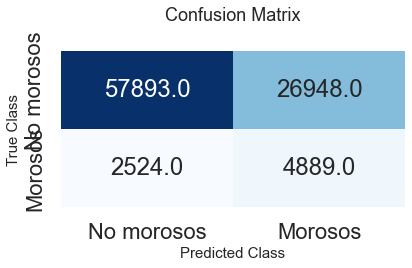

In [59]:
hps.train_evaluate_model(lr, X_train, X_test, y_train, y_test)

---

### 4.5.2 Random Forest Classifier

In [60]:
rfc =  RandomForestClassifier(random_state=REP_SEED, max_depth=10, max_features="sqrt", n_estimators=5, n_jobs=-1) 

Train data: 
              precision    recall  f1-score   support

           0     0.7244    0.7422    0.7332     17412
           1     0.7357    0.7176    0.7265     17412

    accuracy                         0.7299     34824
   macro avg     0.7300    0.7299    0.7299     34824
weighted avg     0.7300    0.7299    0.7299     34824

Test data: 
              precision    recall  f1-score   support

           0     0.9545    0.6598    0.7802     84841
           1     0.1411    0.6400    0.2313      7413

    accuracy                         0.6582     92254
   macro avg     0.5478    0.6499    0.5057     92254
weighted avg     0.8891    0.6582    0.7361     92254

ROC-AUC train:  0.7298989202848609
ROC-AUC test:  0.6498543017755943


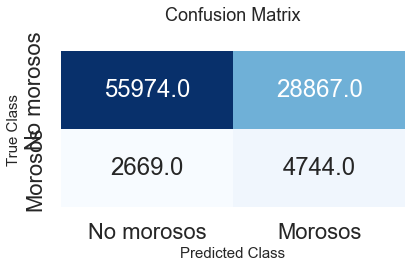

In [61]:
hps.train_evaluate_model(rfc, X_train, X_test, y_train, y_test)

---

### 4.5.3 Gradient Boosting

In [62]:
gb =  GradientBoostingClassifier(random_state=REP_SEED, max_depth=5, n_estimators=300)

Train data: 
              precision    recall  f1-score   support

           0     0.7687    0.7707    0.7697     17412
           1     0.7701    0.7681    0.7691     17412

    accuracy                         0.7694     34824
   macro avg     0.7694    0.7694    0.7694     34824
weighted avg     0.7694    0.7694    0.7694     34824

Test data: 
              precision    recall  f1-score   support

           0     0.9579    0.6949    0.8055     84841
           1     0.1569    0.6501    0.2528      7413

    accuracy                         0.6913     92254
   macro avg     0.5574    0.6725    0.5291     92254
weighted avg     0.8935    0.6913    0.7610     92254

ROC-AUC train:  0.769383184011027
ROC-AUC test:  0.6724811393769388


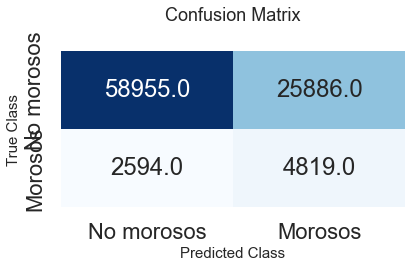

In [63]:
hps.train_evaluate_model(gb, X_train, X_test, y_train, y_test)

---

### 4.5.4 Adaboost Classifier



In [64]:
adb =  AdaBoostClassifier(random_state=REP_SEED, n_estimators=300, learning_rate=0.3)

Train data: 
              precision    recall  f1-score   support

           0     0.6816    0.6903    0.6859     17412
           1     0.6863    0.6776    0.6819     17412

    accuracy                         0.6839     34824
   macro avg     0.6840    0.6839    0.6839     34824
weighted avg     0.6840    0.6839    0.6839     34824

Test data: 
              precision    recall  f1-score   support

           0     0.9564    0.7182    0.8203     84841
           1     0.1623    0.6248    0.2577      7413

    accuracy                         0.7107     92254
   macro avg     0.5593    0.6715    0.5390     92254
weighted avg     0.8925    0.7107    0.7751     92254

ROC-AUC train:  0.6839248793935218
ROC-AUC test:  0.6715134751719801


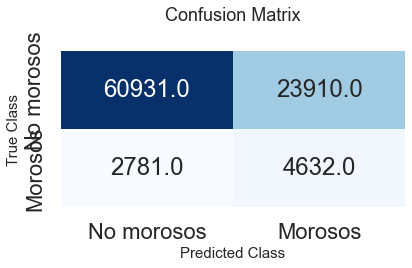

In [65]:
hps.train_evaluate_model(adb, X_train, X_test, y_train, y_test)

---

### 4.5.5 Voting Classifier

In [66]:
vc = VotingClassifier([("lr", lr), ("gb", gb), ("adb", adb)], voting="hard", n_jobs=-1)

Train data: 
              precision    recall  f1-score   support

           0     0.7031    0.7095    0.7062     17412
           1     0.7068    0.7004    0.7036     17412

    accuracy                         0.7049     34824
   macro avg     0.7049    0.7049    0.7049     34824
weighted avg     0.7049    0.7049    0.7049     34824

Test data: 
              precision    recall  f1-score   support

           0     0.9580    0.7056    0.8127     84841
           1     0.1609    0.6459    0.2576      7413

    accuracy                         0.7008     92254
   macro avg     0.5594    0.6758    0.5351     92254
weighted avg     0.8939    0.7008    0.7681     92254

ROC-AUC train:  0.7049161497817596
ROC-AUC test:  0.6757590844904247


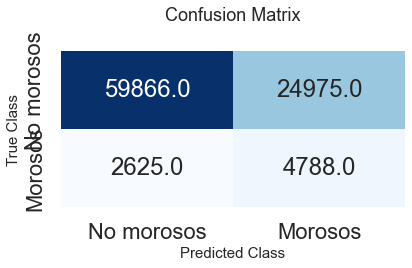

In [67]:
hps.train_evaluate_model(vc, X_train, X_test, y_train, y_test)

### 4.6 Selección del mejor modelo

Según las pruebas realizadas, el modelo que presentó mejor desempeño es el modelo de ensamble por Adaboost, se utilizó para evaluar lo siguiente:



### 4.7 Gráfico Curva Roc

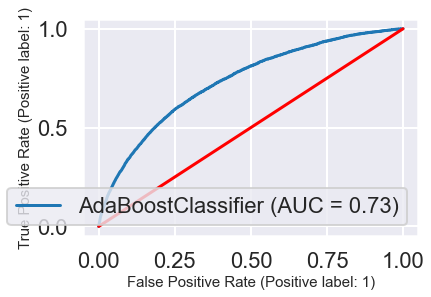

In [68]:
adb_disp = plot_roc_curve(adb, X_test, y_test)
plt.plot([0,1],[0,1],color='red');

### 4.8 Variables más relevantes de modelo seleccionado AdaBoostClassifier

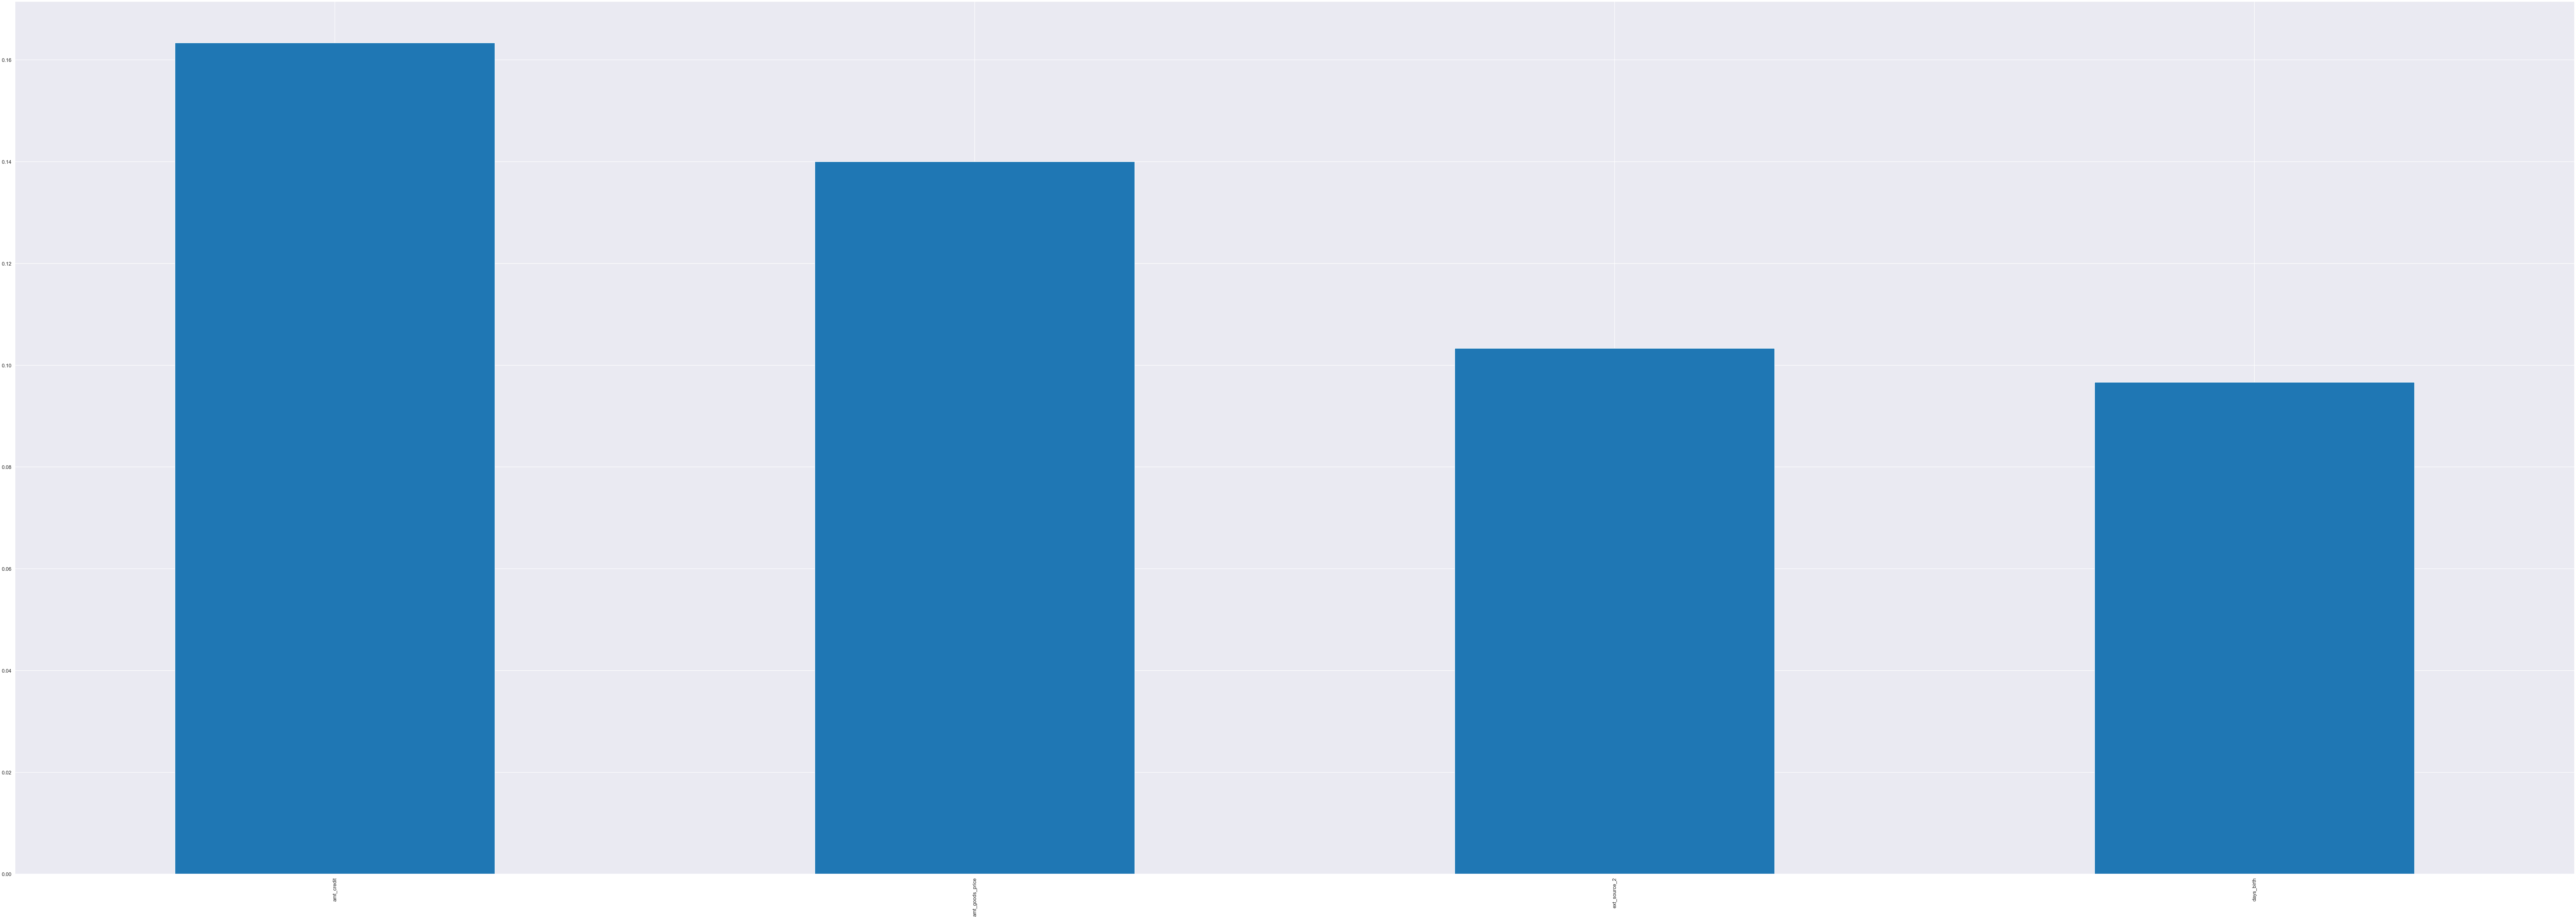

In [69]:
fi = adb.feature_importances_
feature_names = adb.feature_names_in_
plt.figure(figsize=(200,70))
features = pd.Series(fi,index=feature_names).sort_values(ascending=False)
features[:4].plot(kind='bar');

In [70]:
pd.DataFrame(features[:4], columns=['Importance'])

,Importance
amt_credit,0.163333
amt_goods_price,0.140000
ext_source_2,0.103333
days_birth,0.096667


### 4.9 Serialización del modelo

In [ ]:
dump(lr, 'ortorgar_credito_modelo_lr.sav')
dump(rfc, 'ortorgar_credito_modelo_rfc.sav')
dump(gb, 'ortorgar_credito_modelo_gb.sav')
dump(adb, 'ortorgar_credito_modelo_adb.sav')
dump(vc, 'ortorgar_credito_modelo_vc.sav')
